In [1]:
import numpy as np
import cv2
import math
from PIL import Image, ImageStat
import sys
from os import listdir
import time
import os.path
import os
import tensorflow as tf
import shutil

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
path1 = "/Users/caijieyang/Desktop/allgoodthinghere/" #change the path to the local env path
path2 = "/Users/caijieyang/Desktop/allgoodthinghere/mark_output" #change the path to the local env path

In [3]:
"""
The first stage is do the classification.

Firstly, convert the picture into data. Then use the model we built to classify 
the pictures.
"""
def convert(dir):
    file_list=listdir(dir)
    for filename in file_list:
        if "panorama" in filename and "png" in filename and "Copy" not in filename and "cropped" not in filename and "clustered" not in filename and "mark" not in filename and "copy" not in filename:
            path=""
            path=dir+filename
            im=Image.open(path)
            out=im.resize((416,208),Image.ANTIALIAS)
            print ("%s has been resized"%filename)
            if not os.path.exists(dir+'/temp'):
                os.makedirs(dir+'/temp') 
                print (' temp dir created')
            out.save(dir+'/temp/'+filename)

def get_image(image,temp_path):
    """
    Get a numpy 2D array of an image so that one can access RGBA[x][y] or RGBA[x,y].
    
    Also get a cropped image for further use for hsv and k-means clustering
    
    """
    origin = Image.open(temp_path+image, 'r')
    width, height = origin.size
    area = (0, 0, width, 0.5*height)
    image = origin.crop(area) # crop top half of the image
#     result = Image.fromarray(image.astype(np.uint8))
    image.save(temp_path+file+"_cropped.png")
    width, height = image.size
#     print (image.size)
    pixel_values = list(image.getdata())
    if image.mode == 'RGBA':
        channels = 4
    elif image.mode == 'L':
        channels = 1
    else:
        print("Unknown mode: %s" % image.mode)
        return None
    pixel_values = np.array(pixel_values).reshape((height, width, channels))

    return pixel_values #return pixels matrix with RGBA value, and cropped half image

def RGB_array(pixels):
    """
    Get a numpy 2D array of an image so that one can access brightness[x][y]   
    """
    rgb=[[0 for x in range(len(pixels[0]))] for y in range(len(pixels))]
    r,g,b=[],[],[]
    # Matrix = [[0 for x in range(w)] for y in range(h)]
    for i in range(len(pixels)):
        for j in range(len(pixels[0])):
            R,G,B,A=pixels[i,j]
            rgb[i][j]=[R,G,B]
            r.append(R)
            g.append(G)
            b.append(B)
    rgb2 = r+g+b
    return rgb2

In [4]:
"""
Here is the stage of converting the image into data(metrix: a row is image. Each instance
has 129792 values, First 43264 values are R, then G, B)
"""
# path1 = r"/Users/caijieyang/Desktop/allgoodthinghere/"
convert(path1)
temp_path = path1+"/temp/"
files= listdir(temp_path)

train_x = []
file_class={}
file_order=[]
for file in sorted(files):
    if "panorama" in file and "png" in file and "Copy" not in file and "cropped" not in file and "clustered" not in file and "mark" not in file and "copy" not in file:
        print(file+"------")
        file_order.append(file)
        file_class[file]=0
#         file=path1+file
        pixels =get_image(file,temp_path)
#         print (np.shape(pixels))
            # print (pixel1)
        image_rgb = RGB_array(pixels) 
#             edge_cal(file)
        image_rgb=np.asarray(image_rgb)
        print(np.shape(image_rgb))
#         image_rgb=image_rgb.reshape((43264,3))
        train_x.append(image_rgb)
        print(file,np.shape(train_x))

panorama-kzo4CopdKTYYE7UTiMHycQ-1.png has been resized
panorama-_B4o_t61OJyW17t9EyeMeQ-1.png has been resized
panorama-1znusCdNGC6VApjoDrnd2A-1.png has been resized
panorama-69CTJkcYVmvr7WexAc7b1w-1.png has been resized
panorama--aUuP54DEL1iSvsEpfW1wg-1.png has been resized
panorama-4UwYReXSp6bQ4Aba8lIywA-1.png has been resized
panorama--Uu33K5tnOAC_PoGWiowcQ-1.png has been resized
panorama--Uu33K5tnOAC_PoGWiowcQ-1.png------
(129792,)
panorama--Uu33K5tnOAC_PoGWiowcQ-1.png (1, 129792)
panorama--aUuP54DEL1iSvsEpfW1wg-1.png------
(129792,)
panorama--aUuP54DEL1iSvsEpfW1wg-1.png (2, 129792)
panorama-1znusCdNGC6VApjoDrnd2A-1.png------
(129792,)
panorama-1znusCdNGC6VApjoDrnd2A-1.png (3, 129792)
panorama-4UwYReXSp6bQ4Aba8lIywA-1.png------
(129792,)
panorama-4UwYReXSp6bQ4Aba8lIywA-1.png (4, 129792)
panorama-69CTJkcYVmvr7WexAc7b1w-1.png------
(129792,)
panorama-69CTJkcYVmvr7WexAc7b1w-1.png (5, 129792)
panorama-_B4o_t61OJyW17t9EyeMeQ-1.png------
(129792,)
panorama-_B4o_t61OJyW17t9EyeMeQ-1.png (6,

In [5]:
"""
This part is same as it in the training part since we want restore the same model.
"""

# 2.function
# 2.1 # init weight random distribution
def weights(shape):
    return tf.Variable(tf.random_normal(shape=shape, mean=0, stddev=0.1))
# 2.2 init bias
def biases(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

# 2.3 #     
# x input tensor of shape [batch, in_height, in_width, in_channels]
# W filter/kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]
# strides[0]=strides[3]=1 strides[x] stands "x"direction, strides[y]stands "y" dicrection
# padding: "SAME",OR "VALID"
def conv2d(x, W):
    return tf.nn.conv2d(input=x, filter=W, strides=[1,1,1,1], padding='SAME', use_cudnn_on_gpu=True)
# 2.4 pooling layer
def max_pool(x):
    return tf.nn.max_pool(value=x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


# compute accuracy
def compute_accuracy(x_test, y_test):
    global predict_function
    predict_test = sess.run(predict_function, feed_dict={xs:x_test})
    y_test_one_hot = tf.one_hot(y_test, depth = 4)
    correct_num = tf.equal(tf.argmax(predict_test, 1), tf.argmax(y_test_one_hot, 1))
    # calculate mean then turn to float32
    accuracy = tf.reduce_mean(tf.cast(correct_num, tf.float32))
    return sess.run(accuracy, feed_dict={xs:x_test, ys:y_test})

In [6]:
"""
Same defination as it in the training part
"""
# 3.define inpute shape
xs = tf.placeholder(tf.float32, [None, 416*104*3])/255
ys = tf.placeholder(tf.int32, [None])

# 4. build process
# # change xs format into a 4D vector [batch, in_height, in_width, in_channels]
x0 = tf.transpose(tf.reshape(xs, [-1, 3, 104, 416]), perm=[0, 2, 3, 1])

# 4.1 conv1→pooling→conv2→pooling

# after first pooling image is 208x52
# after second pooling image is 104x26
# activation function use relu (alternative)
# conv1 layer uses 30 conv2 uses 60 (alternative)
W_conv1 = weights([5, 5, 3, 30])
b_conv1 = biases([30])
a_conv1 = conv2d(x0, W_conv1) + b_conv1
z_conv1 = tf.nn.relu(a_conv1)
h_conv1 = max_pool(z_conv1)

W_conv2 = weights([5, 5, 30, 60])
b_conv2 = biases([60])
a_conv2 = conv2d(h_conv1, W_conv2) + b_conv2
z_conv2 = tf.nn.relu(a_conv2)
h_conv2 = max_pool(z_conv2)

# output 104*26*60
x_conv0 = tf.reshape(h_conv2, [-1, 104*26*60])
# 4.2 fully connected networks
W_fc1 = weights([104*26*60, 1024])
b_fc1 = biases([1024])
a_fc1 = tf.matmul(x_conv0, W_fc1) + b_fc1
z_fc1 = tf.nn.sigmoid(a_fc1)
"""
==========================drop out

"""
# drop_prob = tf.placeholder(tf.float32)
# h_fc1_drop = tf.nn.dropout(z_fc1,drop_prob)

W_fc2 = weights([1024, 4])
b_fc2 = biases([4])
a_fc2 = tf.matmul(z_fc1, W_fc2) + b_fc2
# z_fc2 = tf.nn.sigmoid(a_fc2)


# 4.3 prediction function
predict_function = a_fc2

ys_one_hot = tf.one_hot(ys, depth = 4)
# cost_function = tf.reduce_mean(-tf.reduce_sum(ys*tf.log(predict_function), reduction_indices=[1]))
cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=ys_one_hot, logits=predict_function))

# 4.4 Optimizer uses GradientDescentOptimizer
#  which minimise the cost_function
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cost_function)
# train_step = tf.train.AdamOptimizer(0.01).minimize(cost_function)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [7]:
"""
This block is used to restore the model we built. From the file:model.ckpt.meta; 
model.ckpt.index; model.ckpt.data-00000-of-00001; checkpoint (four files)
"""

saver = tf.train.Saver()
with tf.Session() as sess:
    print (path1)
    saver = tf.train.import_meta_graph(path1+'model.ckpt.meta')
    saver.restore(sess,tf.train.latest_checkpoint(path1))
    
    print("model restored")
    count = 0
    for item in train_x:
        
        item = item.reshape((1,129792))
        predict_test = sess.run(predict_function, feed_dict={xs:item})
        temp = predict_test[0].tolist()
        label=temp.index(max(temp))+1
        if label==1:
            file_class[file_order[count]]="Cloudy"
        elif label==2:
            file_class[file_order[count]]="BigBuilding"
        elif label==3:
            file_class[file_order[count]]="BridgeTop"
        elif label==4:
            file_class[file_order[count]]="TreeTop"
        count+=1

/Users/caijieyang/Desktop/allgoodthinghere/
INFO:tensorflow:Restoring parameters from /Users/caijieyang/Desktop/allgoodthinghere/model.ckpt
model restored


In [8]:
"""
Until now, the classification is finished. The picture label is stored in a dictionary: 
file_class. Key: picture name, Value: label.
"""
for i in file_class:
    print(i+"=  "+str(file_class[i]))

# remove content in temp dir
shutil.rmtree(temp_path)
os.mkdir(temp_path)

panorama--Uu33K5tnOAC_PoGWiowcQ-1.png=  Cloudy
panorama--aUuP54DEL1iSvsEpfW1wg-1.png=  Cloudy
panorama-1znusCdNGC6VApjoDrnd2A-1.png=  BigBuilding
panorama-4UwYReXSp6bQ4Aba8lIywA-1.png=  Cloudy
panorama-69CTJkcYVmvr7WexAc7b1w-1.png=  Cloudy
panorama-_B4o_t61OJyW17t9EyeMeQ-1.png=  Cloudy
panorama-kzo4CopdKTYYE7UTiMHycQ-1.png=  Cloudy


In [9]:
"""
Classification part ends
=========================
Sky marking part starts
"""

'\nClassification part ends\n=========================\nSky marking part starts\n'

In [10]:
true_po_list=[] # recall list for all test files
precision_list=[] # precision list for all test files
hsl_acc_list=[] # percentage of skys pixels marked by hsl based method 
manual_acc_list=[] # percentage of skys pixels marked by human
edge_list=[] # percentage of edge pixels marked by hsl based method 
 #record the marking start time
# K=4

In [11]:
def get_image(image_path):
    """
    Get a numpy 2D array of an image so that one can access RGBA[x][y] or RGBA[x,y].
    
    Also get a cropped image for further use for hsv and k-means clustering
    
    """
    origin = Image.open(image_path, 'r') 
    width, height = origin.size
    area = (0, 0, width, 0.5*height)
    image = origin.crop(area) # crop top half of the image
#     result = Image.fromarray(image.astype(np.uint8))
    image.save(file+"_cropped.png") #save cropped image
    width, height = image.size
#     print (image.size)
    pixel_values = list(image.getdata()) 
    if image.mode == 'RGBA':
        channels = 4
    elif image.mode == 'L':
        channels = 1
    else:
        print("Unknown mode: %s" % image.mode)
        return None
#     pixel_values = np.array(pixel_values).reshape((width, height, channels))
    pixel_values = np.array(pixel_values).reshape((height, width, channels)) #save image as array
#     print (np.shape(pixel_values))

    return pixel_values,image,origin #return pixels matrix with RGBA value, and cropped half image

In [12]:
def get_bri(pixels):
    """
    Get a numpy 2D array of an image so that one can access brightness[x][y]
       
    """
    brightness=[[0 for x in range(len(pixels[0]))] for y in range(len(pixels))]
    # Matrix = [[0 for x in range(w)] for y in range(h)]
    for i in range(len(pixels)):
        for j in range(len(pixels[0])):
            R,G,B,A=pixels[i,j]
            brightness[i][j]=0.2126*R + 0.7152*G + 0.0722*B #brightness calculator
    return brightness

In [13]:
def hsv( image ):
    """
    Get a numpy 2D array of an image so that one can access HSV[x][y]
       
    """
    img = np.array(image)
    HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     H,S,V=cv2.split(HSV)
    #H = HSV[:,:,0]
    #S = HSV[:,:,1].mean
    #V = HSV[:,:,2].mean
    #return H,S,V
#     H=np.mean(H)
#     S=np.mean(S)
#     V=np.mean(V)
    return HSV

In [14]:
def hls(image):
    """
    Get a numpy 2D array of an image so that one can access HLS[x][y]
       
    """
    img = np.array(image)
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return HLS

In [15]:
"""
K-means clustering to segment the image into K color class 

filename_clustered(number of clusters).png is used as output

"""
def K_means(file,K):
    
    nametemp = file 

    file=(file+"_cropped.png")


    img = cv2.imread(file)
#     img = np.array(image)
    Z = img.reshape((-1,3))#reshape array into n rows and 3 colunms

    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,50,cv2.KMEANS_PP_CENTERS)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    label2=label.reshape((len(img),len(img[0]))) #save the label into 2D array corresponding to image shape
    res2 = res.reshape((img.shape))
    result = Image.fromarray(res2.astype(np.uint8))
    result.save(nametemp+"_clustered"+str(K)+".png")
    return (label2) 

In [16]:
"""
mark out sky by using HSL color filtering
"""

def mark_sky(pixels,label2,image,file,skyreq,H_uplimit,H_downlimit,L_lightness,L_gray,S_gray): 
    counterclass_skypre={} #dict for counting sky pixels with regard to each label(key:label value: count)
    counterclass_all={} #dict for counting all pixels with regard to each label(key:label value: count)
    Skypre=[[0 for x in range(len(pixels[0]))] for y in range(len(pixels))] 
    for i in range(len(label2)):
        for j in range(len(label2[0])):
            if label2[i][j] not in counterclass_all:
                counterclass_all[label2[i][j]]=1
            else:            
                counterclass_all[label2[i][j]]+=1
            #HSL colour filtering condition
            if H_uplimit*180>=HLS[i][j][0] and HLS[i][j][0]>=H_downlimit*180\
                or HLS[i][j][1]>=L_lightness*255 \
                or (HLS[i][j][1]>L_gray*255 and HLS[i][j][2]<=S_gray*255):
                Skypre[i][j]=1
                if label2[i][j] not in counterclass_skypre:
                    counterclass_skypre[label2[i][j]]=1
                else:
                    counterclass_skypre[label2[i][j]]+=1
        skylabel_list=[] #list of sky labels
        for i in counterclass_skypre:
            if counterclass_skypre[i]/counterclass_all[i]>skyreq: #if there is enough sky pixels in one cluster
                skylabel_list.append(i)
#         print (skylabel_list)

    """
    output the image with the marked sky region
    """
    RED = 0
    GREEN = 1
    BLUE = 2

    data = np.asarray(image,dtype="int32")
#     print (np.shape(data))
    for i in range(len(pixels)):
        for j in range(len(pixels[0])):
            if label2[i][j] in skylabel_list:
                data[i, j, GREEN] = 0
                data[i, j, RED] = 0
                data[i, j, BLUE] = 255
            else:
                continue
    result = Image.fromarray(data.astype(np.uint8))
    result.save(file+"_sky_mark"+str(skyreq)+".png")
    
    return data
    
    
#     """
#     calculate true positive rate
#     """
#     true_sky_counter=0
#     true_positive_counter=0
#     false_positive_counter=0
#     tmpfile=file
#     file = file.replace('.png',' - Copy.png') #replace the name with the manual marking image
#     if not os.path.isfile(file):
#         return 
# #     marked_image=Image.open(file, 'r')
#     marked_pixel_values = cv2.imread(file)
#     #count the manual marked sky pixels
#     for i in range(int(len(marked_pixel_values)/2+1)):
#         for j in range(len(marked_pixel_values[0])):
#             if marked_pixel_values[i][j][0] == 255 and marked_pixel_values[i][j][1] == 0 and marked_pixel_values[i][j][2] == 0 :
#                 true_sky_counter+=1
#                 if data[i][j][0] == 0 and data[i][j][1] == 0 and data[i][j][2] == 255:
#                     true_positive_counter+=1 #true positive counter
#             else:
#                 if data[i][j][0] == 0 and data[i][j][1] == 0 and data[i][j][2] == 255:
#                     false_positive_counter+=1 #false positive counter
# #                 continue
# #     print ("true_positive_rate/recall for file ",tmpfile," is: ",true_positive_counter/true_sky_counter)
#     if true_sky_counter==0:
#         temp=0
#         true_po_list.append(temp)
#     else:
#         true_po_list.append(true_positive_counter/true_sky_counter)
# #     print ("precision for file ",tmpfile," is: ",true_positive_counter/(true_positive_counter+false_positive_counter))
#     if true_positive_counter==0:
#         temp=0
#         precision_list.append(temp)
#     else:
#         precision_list.append(true_positive_counter/(true_positive_counter+false_positive_counter))
#     hsl_acc_list.append((true_positive_counter+false_positive_counter)/((len(marked_pixel_values)/2+1)*len(marked_pixel_values[0])))
#     manual_acc_list.append(true_sky_counter/((len(marked_pixel_values)/2+1)*len(marked_pixel_values[0])))    
#     print ("program marked proportion:", (true_positive_counter+false_positive_counter)/((len(marked_pixel_values)/2+1)*len(marked_pixel_values[0])))
#     print ("manually marked proportion:", true_sky_counter/((len(marked_pixel_values)/2+1)*len(marked_pixel_values[0])))
#     print ("false positive count:",false_positive_counter)

In [17]:
def output_evaluation(file,data):
    """
    calculate recall and precision if manual marking is provided 
    manual marking is named as file = file.replace('.png',' - Copy.png')
    for example 1.png's manual marking is called 1 - Copy.png
    """
    true_sky_counter=0
    true_positive_counter=0
    false_positive_counter=0
    tmpfile=file
    file = file.replace('.png',' - Copy.png') #replace the name with the manual marking image
    if not os.path.isfile(file):
        return 
#     marked_image=Image.open(file, 'r')
    marked_pixel_values = cv2.imread(file)
    #count the manual marked sky pixels
    for i in range(int(len(marked_pixel_values)/2+1)):
        for j in range(len(marked_pixel_values[0])):
            if marked_pixel_values[i][j][0] == 255 and marked_pixel_values[i][j][1] == 0 and marked_pixel_values[i][j][2] == 0 :
                true_sky_counter+=1
                if data[i][j][0] == 0 and data[i][j][1] == 0 and data[i][j][2] == 255:
                    true_positive_counter+=1 #true positive counter
            else:
                if data[i][j][0] == 0 and data[i][j][1] == 0 and data[i][j][2] == 255:
                    false_positive_counter+=1 #false positive counter
#                 continue
#     print ("true_positive_rate/recall for file ",tmpfile," is: ",true_positive_counter/true_sky_counter)
    if true_sky_counter==0:
        temp=0
        true_po_list.append(temp)
        print ("recall rate: 0")
    else:
        true_po_list.append(true_positive_counter/true_sky_counter)
        print ("Recall rate:", true_positive_counter/true_sky_counter)
#     print ("precision for file ",tmpfile," is: ",true_positive_counter/(true_positive_counter+false_positive_counter))
    if true_positive_counter==0:
        temp=0
        precision_list.append(temp)
        print ("precision rate: 0")
    else:
        precision_list.append(true_positive_counter/(true_positive_counter+false_positive_counter))
        print ("precision rate:", true_positive_counter/(true_positive_counter+false_positive_counter))
    hsl_acc_list.append((true_positive_counter+false_positive_counter)/((len(marked_pixel_values)/2+1)*len(marked_pixel_values[0])))
    manual_acc_list.append(true_sky_counter/((len(marked_pixel_values)/2+1)*len(marked_pixel_values[0])))    
    print ("program marked proportion:", (true_positive_counter+false_positive_counter)/((len(marked_pixel_values)/2+1)*len(marked_pixel_values[0])))
    print ("manually marked proportion:", true_sky_counter/((len(marked_pixel_values)/2+1)*len(marked_pixel_values[0])))
#     print ("false positive count:",false_positive_counter)

In [18]:
def edge_cal(file):
    """
    edge detection: generate a matrix with edge pixel has value 255, not used in the program
    """
    from matplotlib import pyplot as plt
    file=(file+"_cropped.png")
    img = cv2.imread(file,0)
    edges = cv2.Canny(img,150,500)
    result = Image.fromarray(edges.astype(np.uint8))
    result.save(file+"edged.png")

    """
    proportion of edge pixel 
    threshold 0.1 dedicated for case which has many trees
    """

    # for i in range(len(edges)):
    #     for j in range(len(edges[i])):
    counter = 0
    for i in edges:
        for j in i:
            if j == 255:
                counter+=1
    sum=len(edges)*len(edges[0])
#     print ("edged pixels proportions for ",file, ": ",counter/sum)
    edge_list.append(counter/sum)

In [19]:
"""
Load and feature extraction and calculation
"""
# avg_recall=[]
# avg_pre=[]
# path1 = "/Users/caijieyang/Desktop/allgoodthinghere"

files= listdir(path1)
# Sgray=0.0
    
# while S_gray<=1:
# while Sgray<=1:
true_po_list=[]
precision_list=[]
edge_list=[]
hsl_acc_list=[]
manual_acc_list=[]
str_1="panorama-1znusCdNGC6VApjoDrnd2A-1.png"
str_2="panorama-kzo4CopdKTYYE7UTiMHycQ-1.png"
for file in files:
    if "panorama" in file and "png" in file and "Copy" not in file and "cropped" not in file and "clustered" not in file and "mark" not in file and "copy" not in file:
        start_time = time.time()
        if file_class[file]=="BigBuilding":
            
            print ("class: BigBuilding: ", file)
            command="python Pymeanshiftcomb.py "+file
            os.system(command)
            evaluation_file=file+"ms_sky_mark.png"
            print("--- %s seconds ---" % (time.time() - start_time))
            if os.path.isfile(evaluation_file):
                data_ori=Image.open(evaluation_file, 'r')
                data = np.asarray(data_ori,dtype="int32")
                output_evaluation(file,data)
            print ("####################################################")
            continue
#             K=8
#             skyreq=0.6
#             H_uplimit=0.75
#             H_downlimit=0.3
#             L_lightness=0.95
#             L_gray=0.7
#             S_gray=0.1
#         if dict[file]=="Bigsky":
#             print ("class: Bigsky: ", file)
#             K=12
#             skyreq=0.7
#             H_uplimit=0.75
#             H_downlimit=0.3
#             L_lightness=0.95
#             L_gray=0.7
#             S_gray=0.1
        if file_class[file]=="BridgeTop":
            print ("class: BuildingTop: ", file)
            K=12
            skyreq=0.7
            H_uplimit=0.75
            H_downlimit=0.3
            L_lightness=0.95
            L_gray=0.75
            S_gray=0.2
        if file_class[file]=="TreeTop":
            print ("class: TreeTop: ", file)
            K=14
            skyreq=0.6
            H_uplimit=0.75
            H_downlimit=0.3
            L_lightness=0.95
            L_gray=0.75
            S_gray=0.2
        if file_class[file]=="Cloudy":
            print ("class: Cloudy: ", file)
            K=6
            skyreq=0.4
            H_uplimit=0.75
            H_downlimit=0.3
            L_lightness=0.95
            L_gray=0.65
            S_gray=0.2
        
        pixels,image,origin=get_image(file)
#         print (np.shape(pixels))
            # print (pixel1)
#         brightness=get_bri(pixels)
#         HSV=hsv(image)
        HLS=hls(image)
        label2=K_means(file,K)
#             edge_cal(file)
#         brightness=np.asarray(brightness)
        data=mark_sky(pixels,label2,origin,file,skyreq,H_uplimit,H_downlimit,L_lightness,L_gray,S_gray)
        print("--- %s seconds ---" % (time.time() - start_time))
        output_evaluation(file,data)
#             filesig=file
        print ("skyreq: ",skyreq)
        print ("H_uplimit: ",H_uplimit)
        print ("H_downlimit: ",H_downlimit)
        print ("L_lightness:", L_lightness)
        print ("L_gray: ", L_gray)
        print ("S_gray: ", S_gray)
        print ("####################################################")
if true_po_list:
    print ("average true positive rate: ",np.mean(true_po_list))
# avg_recall.append(np.mean(true_po_list))
if precision_list:
    print ("average precision rate: ",np.mean(precision_list))
# avg_pre.append(np.mean(precision_list))
#     print ("average edge rate: ",np.mean(edge_list))
print ("####################################################")
    #         print (np.shape(HSV))
    #         print (np.shape(HLS))
# print (avg_recall)
# print (avg_pre)
    

class: Cloudy:  panorama-kzo4CopdKTYYE7UTiMHycQ-1.png
--- 3.5550129413604736 seconds ---
Recall rate: 0.9957059613155165
precision rate: 0.9502420205990465
program marked proportion: 0.7900775211630475
manually marked proportion: 0.7540025763709974
skyreq:  0.4
H_uplimit:  0.75
H_downlimit:  0.3
L_lightness: 0.95
L_gray:  0.65
S_gray:  0.2
####################################################
class: Cloudy:  panorama-_B4o_t61OJyW17t9EyeMeQ-1.png
--- 3.1671481132507324 seconds ---
Recall rate: 0.9998082890149605
precision rate: 0.9440641488940886
program marked proportion: 0.8577532664703718
manually marked proportion: 0.8099293798306956
skyreq:  0.4
H_uplimit:  0.75
H_downlimit:  0.3
L_lightness: 0.95
L_gray:  0.65
S_gray:  0.2
####################################################
class: BigBuilding:  panorama-1znusCdNGC6VApjoDrnd2A-1.png
--- 5.979586839675903 seconds ---
Recall rate: 0.999965276170193
precision rate: 0.9590164844313703
program marked proportion: 0.5180633511225616
manua

In [20]:
from shutil import copyfile
# path2 = "/Users/caijieyang/Desktop/allgoodthinghere/mark_output"
files= listdir(path1)
for file in files:
    if "panorama" in file and "png" in file and "Copy" not in file and "cropped" not in file and "clustered" not in file and "sky_mark" in file and "copy" not in file:
        shutil.copy2(file, path2)

In [21]:
print (true_po_list)
print (precision_list)
# print (avg_recall)
# print (avg_pre)

[0.9957059613155165, 0.9998082890149605, 0.999965276170193, 0.9997548387096774, 0.9965142894513113, 0.9996523401851288, 0.9963713634213666]
[0.9502420205990465, 0.9440641488940886, 0.9590164844313703, 0.9625267865461661, 0.96904194092022, 0.9503473824098493, 0.9404681783955594]


In [22]:
print (hsl_acc_list)
print (manual_acc_list)

# print (pixels[100,200])
# print (HLS[0,:])

[0.7900775211630475, 0.8577532664703718, 0.5180633511225616, 0.9258545730585205, 0.904288967611336, 0.835187016930438, 0.8630325266838424]
[0.7540025763709974, 0.8099293798306956, 0.49684854619065144, 0.8913783584836217, 0.8793591277143908, 0.7939938351122562, 0.8146105539197644]


In [23]:
import matplotlib.pyplot as plt
fit=np.polyfit(manual_acc_list,hsl_acc_list,1)
fit_fn=np.poly1d(fit)
plt.plot(manual_acc_list,hsl_acc_list, 'yo', manual_acc_list, fit_fn(manual_acc_list), '--k')
# plt.xlim(0, 5)
# plt.ylim(0, 12)

Coefficients: 
 [[1.03585207]]
Mean squared error: 0.000075
Variance score: 1.00


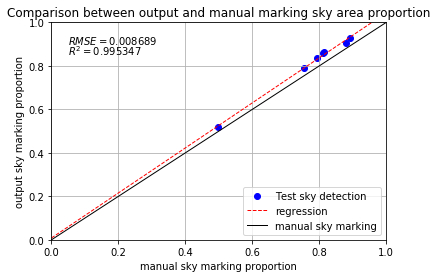

In [24]:
"""
Output regression if manual marking is provided
"""

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
X=np.asarray(manual_acc_list)
Y=np.asarray(hsl_acc_list)
X_train = X.reshape(-1,1)
Y_train = Y.reshape(-1,1)
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X_train, Y_train)
Y_pred = regr.predict(X_train)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
a=np.sqrt(mean_squared_error(Y_train, Y_pred))
print("Mean squared error: %.6f"% mean_squared_error(Y_train, Y_pred))
# Explained variance score: 1 is perfect prediction
b=r2_score(Y_train, Y_pred)
print('Variance score: %.2f' % r2_score(Y_train, Y_pred))
temp=np.asarray([0,1])
Y_pred2 = regr.predict(temp.reshape(-1,1))
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])
point0=plt.scatter(X_train, Y_train,  color='blue',label="Test sky detection")
line1, =plt.plot([0,1], Y_pred2, 'r--', linewidth=1,label="regression")
line2, =plt.plot([0,1], [0,1], color='black', linewidth=1,label="manual sky marking")
plt.legend(handles=[point0,line1,line2],loc="lower right")
plt.xlabel('manual sky marking proportion', fontsize=10)
plt.ylabel('output sky marking proportion', fontsize=10)
plt.text(0.05, 0.9, r'$RMSE=%f$'%a, fontsize=10)
plt.text(0.05, 0.85, r'$R^2=%f$'%b, fontsize=10)
plt.title('Comparison between output and manual marking sky area proportion')
# plt.legend()
# plt.xticks(())
# plt.yticks(())
plt.grid(True)
# plt.show()
plt.savefig('regression_output.png')

In [25]:
# """
# convert brightness into array
# """

# print (np.shape(pixels))
# print (np.shape(image))


# brightness=brightness.transpose()
# print (np.shape(brightness))
# print ("pixel RGBA: ", pixels[0,0])
# print ("cloud brightness:", brightness[0][0])
# print ("cloud RGBA:", pixels[0,0])
# print ("sky brightness:", brightness[94][462])
# print ("sky RGBA:", pixels[94,462])
# print ("tree brightness:", brightness[140][127])
# print ("tree RGBA:", pixels[140,127])

In [26]:
# """
# convert img into grayscale
# """
# # grayimg = np.array(img)
# grayimg=cv2.imread(file)
# graypix = cv2.cvtColor(grayimg, cv2.COLOR_RGB2GRAY)

# # graypix=cvtColor(img,COLOR_RGB2GRAY)
# cv2.imwrite('gray_image.png',graypix)


In [27]:
# """
# mark based soly on blue
# """
# RED = 0
# GREEN = 1
# BLUE = 2

# data = np.asarray(image,dtype="int32")
# print (np.shape(data))
# for i in range(len(brightness)):
#     for j in range(len(brightness[0])):
#         if 100<pixels[i][j][1]<255 and pixels[i][j][0]>100 and pixels[i][j][2]>100:
#             data[i, j, GREEN] = 0
#             data[i, j, RED] = 0
#             data[i, j, BLUE] = 255
#         else:
#             continue
# result = Image.fromarray(data.astype(np.uint8))
# result.save("sky_mark1.png")

In [28]:
# """
# transfer image into grayscale
# """

# import numpy as np
# import matplotlib.pyplot as plt

# from skimage import measure


# # Construct some test data
# # x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
# # r = np.sin(np.exp((np.sin(x)**3 + np.cos(y)**2)))

# # Find contours at a constant value of 0.8
# contours = measure.find_contours(img, 0.8)

# # Display the image and plot all contours found
# fig, ax = plt.subplots()
# ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)

# for n, contour in enumerate(contours):
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

# ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])
# plt.show()